# Outlook #

In this colab we will investigate the **value iteration** and **policy iteration** algorithms in a maze environment.

# Installation #

In [2]:
import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from mazemdp.maze_plotter import show_videos
from my_gym.envs.maze_mdp import MazeMDPEnv
from mazemdp import random_policy
import gym
import my_gym

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

Matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:

SIZE = 10
RATIO = 0.3

env = gym.make("MazeMDP-v0", kwargs={"width": SIZE, "height": SIZE, "ratio": RATIO})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.set_no_agent()
env.init_draw("The maze")

Output()

In [4]:
def get_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray) -> np.ndarray:
    # Outputs a policy given the state values
    policy = np.zeros(mdp.nb_states)  # initial state values are set to 0
    for x in range(mdp.nb_states):  # for each state x
        if x not in mdp.terminal_states:
            # Compute the value of the state x for each action u of the MDP action space
            v_temp = []
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp.append(mdp.r[x, u] + mdp.gamma * summ)
            policy[x] = np.argmax(v_temp)
    return policy

In [5]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def value_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # Value Iteration using the state value v
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    stop = False
    v_iterations = 0
    iterations = 0

    video_recorder = VideoRecorder(mdp, "videos/ValueIterationV.mp4", enabled=render)
    mdp.set_title("Value iteration V")
    if render:
        mdp.render()
        video_recorder.capture_frame()
    mdp.set_render_func(mdp.draw_v, lambda draw: draw(v))

    while not stop:
        v_old = v.copy()
        if render:
            mdp.render()
            video_recorder.capture_frame()

        for x in range(mdp.nb_states):  # for each state x
            # Compute the value of the state x for each action u of the MDP action space
            if x not in mdp.terminal_states:
                v_temp = []
                for u in mdp.action_space.actions:
                    # Process sum of the values of the neighbouring states
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ = summ + mdp.P[x, u, y] * v_old[y]
                    v_temp.append(mdp.r[x, u] + mdp.gamma * summ)

                # Select the highest state value among those computed
                v[x] = np.max(v_temp)
                v_iterations += 1
        iterations += 1

        # Test if convergence has been reached
        if (np.linalg.norm(v - v_old)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))

    if render:
        policy = get_policy_from_v(mdp, v)
        mdp.set_render_func(mdp.draw_v_pi, lambda draw: draw(v, policy))
        mdp.render()
        video_recorder.capture_frame()


    video_recorder.close()
    return v, v_list, v_iterations, iterations

In [6]:
v, v_list, v_updates, iterations = value_iteration_v(env, render=True)

Output()

In [7]:

# ------------------ Value Iteration with the Q function ---------------------#
# Given a MDP, this algorithm computes the optimal action value function Q
# It then derives the optimal policy based on this function


from re import A


def value_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    stop = False

    q_updates = 0
    iterations = 0

    if render:
        mdp.init_draw("Value iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Value iteration Q")

        for x in range(mdp.nb_states):
            if x not in mdp.terminal_states:
                for u in mdp.action_space.actions:
                    summ = 0
                    for y in range(mdp.nb_states):
                        summ += mdp.P[x, u, y] * np.max(qold[y, :])
                        
                    q[x,u]= mdp.r[x, u] + mdp.gamma * summ
                    q_updates += 1

        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))
        iterations += 1

    if render:
        mdp.draw_v(q, title="Value iteration Q")
        mdp.mdp.plotter.video_writer.release()

    return q, q_list, q_updates, iterations


In [8]:
q, q_list, q_updates, iterations = value_iteration_q(env, render=True)
print(q_updates, iterations)

Output()

6720 24


In [9]:
def improve_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            v_temp = np.zeros(mdp.action_space.size)
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ

            for u in mdp.action_space.actions:
                if v_temp[u] > v_temp[policy[x]]:
                    policy[x] = u
    return policy

In [10]:
def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_new = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
            v_updates += 1
    return v_new, v_updates



In [11]:

def evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    stop = False
    v_updates = 0
    while not stop:
        vold = v.copy()
        v, v_step_updates = evaluate_one_step_v(mdp, vold, policy)
        v_updates += v_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
    return v, v_updates


**Question:** By using the above functions, fill the code of the `policy_iteration_v(mdp)` function below.

In [12]:
# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes 
# the optimal state value function V and the optimal policy

def policy_iteration_v(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False
    v_updates_total = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration V")

    while not stop:
        vold = v.copy()
        # Step 1 : Policy Evaluation
        v, v_updates = evaluate_v(mdp, policy)
        v_updates_total += v_updates
        if render:
            mdp.draw_v_pi(v, policy, title="Policy iteration V")

        # Step 2 : Policy Improvement
        # À compléter...  
        policy = improve_policy_from_v(mdp, v, policy)
        
        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))
        iterations +=1

    if render:
        mdp.draw_v_pi(v, policy, title="Policy iteration V")
        mdp.mdp.plotter.video_writer.release()

    return v, v_list, v_updates_total, iterations


And finally run it.

In [12]:
v, v_list, v_updates, iterations = policy_iteration_v(env, render=True)
print(v_updates, iterations)

Output()

24290 21


### Policy iteration with the $Q$ function ###


The **policy iteration** algorithm with the $Q$ function is the same as with the $V$ function, but the policy improvement step is more straightforward.

When using $Q$, the Bellman Optimality Equation with deterministic policy $\pi$ for $Q$ becomes: 
$$Q^{\pi}(s,a) = r(s,a) + \gamma \sum_{y \in S}P(s,a,y)Q^{\pi}(y,\pi(y)).$$

The policy can then be updated as follows:
$$\pi^{(t+1)}(s) = \arg\max_aQ^{\pi^{(t)}}(s,a).$$


First, we need to determine a policy from the $Q$ function.

**Question:**  fill the `get_policy_from_q(q)` function, where $q$ is the state-action value function.

In [13]:
def get_policy_from_q(q: np.ndarray) -> np.ndarray:
    # Outputs a policy given the action values
    return np.argmax(q, axis=1)

**Question:** By drawing inspiration on the functions give with the $v$ function, fill the code of the `evaluate_one_step_q(mdp, q, policy)` function below, where $q$ is some action value function, and the `evaluate_q(mdp, policy)` function.

In [14]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
                q_updates += 1
    return qnew, q_updates

In [15]:

def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    q_updates = 0
    while not stop:
        qold = q.copy()
        q, q_step_updates = evaluate_one_step_q(mdp, q, policy)
        q_updates += q_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q, q_updates

**Question:** By using the above functions, fill the code of the `policy_iteration_q(mdp)` function below.

In [16]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
                q_updates += 1
    return qnew, q_updates

def evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function of a policy
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    stop = False
    q_updates = 0
    while not stop:
        qold = q.copy()
        q, q_step_updates = evaluate_one_step_q(mdp, q, policy)
        q_updates += q_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            stop = True
    return q, q_updates
# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes 
# the optimal action value function Q and the optimal policy

def policy_iteration_q(mdp: MazeMDPEnv, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False
    q_total_updates = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q, q_updates = evaluate_q(mdp, policy)
        q_total_updates += q_updates
        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)
        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))
        iterations += 1

    if render:
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list, q_total_updates, iterations


Finally, run it.

In [17]:
q, q_list, q_updates, iterations = policy_iteration_q(env, render=True)
print(q_updates, iterations)

Output()

137200 28


### Study part: Experimental comparisons

We will now compare the efficiency of the various dynamic programming methods using either the $V$ or the  $Q$ functions.

In all your dymanic programming functions, add code to count the number of iterations and the number of elementary $V$ or $Q$ updates. Use the provided `mazemdp.Chrono` class to measure the time taken. You may generate various mazes of various sizes to figure out the influence of the maze topology.

Build a table where you compare the various dymanic programming functions in terms of iterations, elementary operations and time taken.

You can run the `plot_convergence_vi_pi(...)` function provided below to visualize the convergence of the various algorithms.


**Question:** Run the code below and visualize the results of the different algorithms

In [17]:
# Convergence and elemental updates by maze size

from mazemdp import chrono

def plot_iterations_updates_vi_pi(iterations, min_size, max_size):
    maze_sizes = np.arange(min_size, max_size)
    v_updates1 = np.zeros_like(maze_sizes, dtype = float)
    v_updates2 = np.zeros_like(maze_sizes, dtype = float)
    q_updates1 = np.zeros_like(maze_sizes, dtype = float)
    q_updates2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    v_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_temps1 = np.zeros_like(maze_sizes, dtype = float)
    v_temps2 = np.zeros_like(maze_sizes, dtype = float)
    q_temps1 = np.zeros_like(maze_sizes, dtype = float)
    q_temps2 = np.zeros_like(maze_sizes, dtype = float)
    
    render = False
    for i, size in enumerate(maze_sizes):
        print("Processing size ", size)
        for j in range(iterations):
            env = gym.make("MazeMDP-v0", kwargs={"width": size, "height": size, "ratio": 0.4}) 
            # env.init_draw("Maze")
            t = chrono.time.time()
            v, v_list1, v_upd1, v_iter1 = value_iteration_v(env, render)
            v_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list1, q_upd1, q_iter1 = value_iteration_q(env, render)
            q_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            v, v_list2, v_upd2, v_iter2 = policy_iteration_v(env, render)
            v_temps2[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list2, q_upd2, q_iter2 = policy_iteration_q(env, render)
            q_temps2[i] += (chrono.time.time() - t)
            
            v_updates1[i] += v_upd1/iterations
            v_updates2[i] += v_upd2/iterations
            q_updates1[i] += q_upd1/iterations
            q_updates2[i] += q_upd2/iterations
            
            v_iterations1[i] += v_iter1/iterations
            v_iterations2[i] += v_iter2/iterations
            q_iterations1[i] += q_iter1/iterations
            q_iterations2[i] += q_iter2/iterations
    
    # Create two subplots and unpack the output array immediately
    f, axis = plt.subplots(3, 1, sharey=False)
    axis[0].plot(maze_sizes, v_updates1, label='value_updates_v')
    axis[0].plot(maze_sizes, q_updates1, label='value_updates_q')
    axis[0].plot(maze_sizes, v_updates2, label='policy_updates_v')
    axis[0].plot(maze_sizes, q_updates2, label='policy_updates_q')
    
    axis[1].plot(maze_sizes, v_iterations1, label='value_iterations_v')
    axis[1].plot(maze_sizes, q_iterations1, label='value_iterations_q')
    axis[1].plot(maze_sizes, v_iterations2, label='policy_iterations_v')
    axis[1].plot(maze_sizes, q_iterations2, label='policy_iterations_q')
    
    axis[2].plot(maze_sizes, v_temps1, label='value_iterations_v')
    axis[2].plot(maze_sizes, q_temps1, label='value_iterations_q')
    axis[2].plot(maze_sizes, v_temps2, label='policy_iterations_v')
    axis[2].plot(maze_sizes, q_temps2, label='policy_iterations_q')


    plt.xlabel('Maze size')
    
    axis[0].set_title('Elemental updates')
    axis[1].set_title('Number of iterations')
    axis[1].set_title('Time')
    
    axis[0].legend(loc='best')
    axis[1].legend(loc='best')
    axis[2].legend(loc='best')
    plt.savefig("comparison_DP9_on_size.png")
    plt.tight_layout()
    plt.show()


In [19]:
    
plot_iterations_updates_vi_pi(50, 5,10)

Processing size  5
Processing size  6
Processing size  7


KeyboardInterrupt: 

In [18]:
# Convergence and elemental updates by maze size

from mazemdp import chrono

def plot_iterations_updates_vi_pi_ratio():
    ratios = np.arange(0, 0.6, 0.05)
    v_updates1 = np.zeros_like(ratios)
    v_updates2 = np.zeros_like(ratios)
    q_updates1 = np.zeros_like(ratios)
    q_updates2 = np.zeros_like(ratios)
    
    v_iterations1 = np.zeros_like(ratios)
    v_iterations2 = np.zeros_like(ratios)
    q_iterations1 = np.zeros_like(ratios)
    q_iterations2 = np.zeros_like(ratios)
    
    render = False
    size = 6
    for i, ratio in enumerate(ratios):
        env = gym.make("MazeMDP-v0", kwargs={"width": size, "height": size, "ratio": ratio}) 
        v, v_list1, v_updates1[i], v_iterations1[i] = value_iteration_v(env, render)
        q, q_list1, q_updates1[i], q_iterations1[i] = value_iteration_q(env, render)
        v, v_list2, v_updates2[i], v_iterations2[i] = policy_iteration_v(env, render)
        q, q_list2, q_updates2[i], q_iterations2[i] = policy_iteration_q(env, render)
        
    # Create two subplots and unpack the output array immediately
    f, axis = plt.subplots(2, 1, sharey=False)
    axis[0].plot(ratios, v_updates1, label='value_updates_v')
    axis[0].plot(ratios, q_updates1, label='value_updates_q')
    axis[0].plot(ratios, v_updates2, label='policy_updates_v')
    axis[0].plot(ratios, q_updates2, label='policy_updates_q')
    
    axis[1].plot(ratios, v_iterations1, label='value_iterations_v')
    axis[1].plot(ratios, q_iterations1, label='value_iterations_q')
    axis[1].plot(ratios, v_iterations2, label='policy_iterations_v')
    axis[1].plot(ratios, q_iterations2, label='policy_iterations_q')


    plt.xlabel('Maze size')
    axis[0].set_title('Number of elementary updates')
    axis[1].set_title('Number of iterations until convergence')
    axis[0].legend(loc='best')
    axis[1].legend(loc='best')
    # plt.savefig("comparison_DP.png")
    plt.tight_layout()
    plt.show()
    
plot_iterations_updates_vi_pi_ratio()

KeyboardInterrupt: 


Given the results above, discuss the relative computational efficiency of these methods.

### Study part: Generalized Policy Iteration

Code the **generalized policy iteration** algorithm and study the influence of the number of evaluation steps between each improvement step

In [19]:
size = 10
ratio = 0.2
env = gym.make("MazeMDP-v0", kwargs={"width": size, "height": size, "ratio": ratio}) 
env.show

In [20]:
# Convergence and elemental updates by maze size

from mazemdp import chrono
from tqdm import tqdm

def plot_iterations_updates_vi_pi(iterations, min_size, max_size):
    maze_sizes = np.arange(min_size, max_size)
    v_updates1 = np.zeros_like(maze_sizes, dtype = float)
    v_updates2 = np.zeros_like(maze_sizes, dtype = float)
    q_updates1 = np.zeros_like(maze_sizes, dtype = float)
    q_updates2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    v_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations1 = np.zeros_like(maze_sizes, dtype = float)
    q_iterations2 = np.zeros_like(maze_sizes, dtype = float)
    
    v_temps1 = np.zeros_like(maze_sizes, dtype = float)
    v_temps2 = np.zeros_like(maze_sizes, dtype = float)
    q_temps1 = np.zeros_like(maze_sizes, dtype = float)
    q_temps2 = np.zeros_like(maze_sizes, dtype = float)
    
    render = False
    for i, size in tqdm(enumerate(maze_sizes)):
        print("Processing size ", size)
        for j in range(iterations):
            #env = gym.make("MazeMDP-v0", kwargs={"width": size, "height": size, "ratio": 0.4}) 
            # env.init_draw("Maze")
            t = chrono.time.time()
            v, v_list1, v_upd1, v_iter1 = value_iteration_v(env, render)
            v_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list1, q_upd1, q_iter1 = value_iteration_q(env, render)
            q_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            v, v_list2, v_upd2, v_iter2 = policy_iteration_v(env, render)
            v_temps2[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list2, q_upd2, q_iter2 = policy_iteration_q(env, render)
            q_temps2[i] += (chrono.time.time() - t)
            
            v_updates1[i] += v_upd1/iterations
            v_updates2[i] += v_upd2/iterations
            q_updates1[i] += q_upd1/iterations
            q_updates2[i] += q_upd2/iterations
            
            v_iterations1[i] += v_iter1/iterations
            v_iterations2[i] += v_iter2/iterations
            q_iterations1[i] += q_iter1/iterations
            q_iterations2[i] += q_iter2/iterations
    
    # Create two subplots and unpack the output array immediately
    f, axis = plt.subplots(3, 1, sharey=False)
    axis[0].plot(maze_sizes, v_updates1, label='value_updates_v')
    axis[0].plot(maze_sizes, q_updates1, label='value_updates_q')
    axis[0].plot(maze_sizes, v_updates2, label='policy_updates_v')
    axis[0].plot(maze_sizes, q_updates2, label='policy_updates_q')
    
    axis[1].plot(maze_sizes, v_iterations1, label='value_iterations_v')
    axis[1].plot(maze_sizes, q_iterations1, label='value_iterations_q')
    axis[1].plot(maze_sizes, v_iterations2, label='policy_iterations_v')
    axis[1].plot(maze_sizes, q_iterations2, label='policy_iterations_q')
    
    axis[2].plot(maze_sizes, v_temps1, label='value_iterations_v')
    axis[2].plot(maze_sizes, q_temps1, label='value_iterations_q')
    axis[2].plot(maze_sizes, v_temps2, label='policy_iterations_v')
    axis[2].plot(maze_sizes, q_temps2, label='policy_iterations_q')


    plt.xlabel('Maze size')
    
    axis[0].set_title('Elemental updates')
    axis[1].set_title('Number of iterations')
    axis[1].set_title('Time')
    
    axis[0].legend(loc='best')
    axis[1].legend(loc='best')
    axis[2].legend(loc='best')
    plt.savefig("comparison_DP9_on_size.png")
    plt.tight_layout()
    plt.show()


In [21]:
import gym
import my_gym

import os
from typing import Tuple, List

import numpy as np
import matplotlib.pyplot as plt

from mazemdp.maze_plotter import show_videos
from my_gym.envs.maze_mdp import MazeMDPEnv
from mazemdp import random_policy

# For visualization
os.environ["VIDEO_FPS"] = "5"
if not os.path.isdir("./videos"):
    os.mkdir("./videos")

from IPython.display import Video

SIZE = 10
RATIO = 0.3

env = gym.make("MazeMDP-v0", kwargs={"width": SIZE, "height": SIZE, "ratio": RATIO})
env.reset()

# in dynamic programming, there is no agent moving in the environment
env.set_no_agent()
env.init_draw("The maze")



def generalized_evaluate_v(mdp: MazeMDPEnv, policy: np.ndarray, v : np.array, k: int) -> np.ndarray:
    # Outputs the state value function of a policy
    stop = False
    v_updates = 0
    for i in range(k):
        vold = v.copy()
        v, v_step_updates = evaluate_one_step_v(mdp, vold, policy)
        v_updates += v_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(v - vold)) < 0.01:
            return v, v_updates
    return v, v_updates

def evaluate_one_step_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    # Corresponds to one application of the Bellman Operator
    v_updates = 0
    v_new = v.copy()
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            # Process sum of the values of the neighbouring states
            summ = 0
            for y in range(mdp.nb_states):
                summ = summ + mdp.P[x, policy[x], y] * v[y]
            v_new[x] = mdp.r[x, policy[x]] + mdp.gamma * summ
            v_updates += 1
    return v_new, v_updates

def improve_policy_from_v(mdp: MazeMDPEnv, v: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Improves a policy given the state values
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            v_temp = np.zeros(mdp.action_space.size)
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    summ = summ + mdp.P[x, u, y] * v[y]
                v_temp[u] = mdp.r[x, u] + mdp.gamma * summ

            for u in mdp.action_space.actions:
                if v_temp[u] > v_temp[policy[x]]:
                    policy[x] = u
    return policy

# ---------------- Policy Iteration with the V function -----------------#
# Given an MDP, this algorithm simultaneously computes 
# the optimal state value function V and the optimal policy

def generalized_policy_iteration_v(mdp: MazeMDPEnv, k, render: bool = True) -> Tuple[np.ndarray, List[float]]:
    # policy iteration over the v function
    v = np.zeros(mdp.nb_states)  # initial state values are set to 0
    v_list = []
    policy = random_policy(mdp)

    stop = False
    v_updates_total = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration V")

    while not stop:
        vold = v.copy()
        # Step 1 : Policy Evaluation
        v, v_updates = generalized_evaluate_v(mdp, policy, vold, k)
        v_updates_total += v_updates
        if render:
            mdp.draw_v_pi(v, policy, title="Policy iteration V")

        # Step 2 : Policy Improvement
        # À compléter...  
        policy = improve_policy_from_v(mdp, v, policy)
        
        # Check convergence
        if (np.linalg.norm(v - vold)) < 0.01:
            stop = True
        v_list.append(np.linalg.norm(v))
        iterations +=1

    if render:
        mdp.draw_v_pi(v, policy, title="Policy iteration V")
        mdp.mdp.plotter.video_writer.release()

    return v, v_list, v_updates_total, iterations


Output()

In [21]:


v, v_list, v_updates, iterations = generalized_policy_iteration_v(env, 10, render=True)

Output()

In [22]:
# Convergence and elemental updates by maze size

from mazemdp import chrono
from tqdm.notebook import tqdm

def plot_iterations_updates_vi_pi(iterations, min_size, max_size):
    k_values = np.arange(min_size, max_size)
    v_updates1 = np.zeros_like(k_values, dtype = float)
    v_updates2 = np.zeros_like(k_values, dtype = float)
    q_updates1 = np.zeros_like(k_values, dtype = float)
    q_updates2 = np.zeros_like(k_values, dtype = float)
    
    v_iterations1 = np.zeros_like(k_values, dtype = float)
    v_iterations2 = np.zeros_like(k_values, dtype = float)
    q_iterations1 = np.zeros_like(k_values, dtype = float)
    q_iterations2 = np.zeros_like(k_values, dtype = float)
    
    v_temps1 = np.zeros_like(k_values, dtype = float)
    v_temps2 = np.zeros_like(k_values, dtype = float)
    q_temps1 = np.zeros_like(k_values, dtype = float)
    q_temps2 = np.zeros_like(k_values, dtype = float)
    
    render = False
    for i, k in enumerate(k_values):
        print("Processing k ", k)
        for j in tqdm(range(iterations)):
            # env.init_draw("Maze")
            t = chrono.time.time()
            v, v_list1, v_upd1, v_iter1 = value_iteration_v(env, render)
            v_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list1, q_upd1, q_iter1 = value_iteration_v(env, render)
            q_temps1[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            v, v_list2, v_upd2, v_iter2 = generalized_policy_iteration_v(env, k, render)
            v_temps2[i] += (chrono.time.time() - t)
            t = chrono.time.time()
            q, q_list2, q_upd2, q_iter2 = generalized_policy_iteration_v(env, k, render)
            q_temps2[i] += (chrono.time.time() - t)
            
            v_updates1[i] += v_upd1/iterations
            v_updates2[i] += v_upd2/iterations
            q_updates1[i] += q_upd1/iterations
            q_updates2[i] += q_upd2/iterations
            
            v_iterations1[i] += v_iter1/iterations
            v_iterations2[i] += v_iter2/iterations
            q_iterations1[i] += q_iter1/iterations
            q_iterations2[i] += q_iter2/iterations
    
    # Create two subplots and unpack the output array immediately
    f, axis = plt.subplots(3, 1, sharey=False)
    axis[0].plot(k_values, v_updates1, label='value_updates_v')
    axis[0].plot(k_values, q_updates1, label='value_updates_v')
    axis[0].plot(k_values, v_updates2, label='generalized_policy_iteration_v')
    axis[0].plot(k_values, q_updates2, label='generalized_policy_iteration_v')
    
    axis[1].plot(k_values, v_iterations1, label='value_updates_v')
    axis[1].plot(k_values, q_iterations1, label='value_updates_v')
    axis[1].plot(k_values, v_iterations2, label='generalized_policy_iteration_v')
    axis[1].plot(k_values, q_iterations2, label='generalized_policy_iteration_v')
    
    axis[2].plot(k_values, v_temps1, label='value_iterations_v')
    axis[2].plot(k_values, q_temps1, label='value_iterations_q')
    axis[2].plot(k_values, v_temps2, label='policy_iterations_v')
    axis[2].plot(k_values, q_temps2, label='policy_iterations_q')


    plt.xlabel('Maze size')
    
    axis[0].set_title('Elemental updates')
    axis[1].set_title('Number of iterations')
    axis[1].set_title('Time')
    
    axis[0].legend(loc='best')
    axis[1].legend(loc='best')
    axis[2].legend(loc='best')
    plt.savefig("comparison_DP9_on_size.png")
    plt.tight_layout()
    plt.show()
    
    updates = [v_updates1, q_updates1, v_updates2, q_updates2]
    iterations = [v_iterations1, q_iterations1, v_iterations2, q_iterations2]
    temps = [v_temps1, q_temps1, v_temps2, q_temps2]
    
    
    return k_values, updates,iterations,temps


In [23]:
k_values, updates,iterations,temps = plot_iterations_updates_vi_pi(10, 1, 30)

Processing k  1


  0%|          | 0/10 [00:00<?, ?it/s]

Processing k  2


  0%|          | 0/10 [00:00<?, ?it/s]

Processing k  3


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [65]:
def evaluate_one_step_q(mdp: MazeMDPEnv, q: np.ndarray, policy: np.ndarray) -> np.ndarray:
    # Outputs the state value function after one step of policy evaluation
    qnew = q.copy()  # initial action values are set to 0
    q_updates = 0
    for x in range(mdp.nb_states):  # for each state x
        # Compute the value of the state x for each action u of the MDP action space
        if x not in mdp.terminal_states:
            for u in mdp.action_space.actions:
                # Process sum of the values of the neighbouring states
                summ = 0
                for y in range(mdp.nb_states):
                    
                    summ += mdp.P[x, u, y] * q[y, policy[y]]
                    
                qnew[x, u] = mdp.r[x, u] + mdp.gamma * summ
                q_updates += 1
    return qnew, q_updates

def generalized_evaluate_q(mdp: MazeMDPEnv, policy: np.ndarray,  q : np.ndarray, k: int) -> np.ndarray:
    # Outputs the state value function of a policy
    stop = False
    q_updates = 0
    for i in range(k):
        qold = q.copy()
        q, q_step_updates = evaluate_one_step_q(mdp, q, policy)
        q_updates += q_step_updates
        # Test if convergence has been reached
        if (np.linalg.norm(q - qold)) < 0.01:
            return q, q_updates
    return q, q_updates

# ---------------- Policy Iteration with the Q function -----------------#
# Given a MDP, this algorithm simultaneously computes 
# the optimal action value function Q and the optimal policy

def generalized_policy_iteration_q(mdp: MazeMDPEnv, k: int, render: bool = True, ) -> Tuple[np.ndarray, List[float]]:
    """policy iteration over the q function."""
    q = np.zeros((mdp.nb_states, mdp.action_space.size))  # initial action values are set to 0
    q_list = []
    policy = random_policy(mdp)

    stop = False
    q_total_updates = 0
    iterations = 0

    if render:
        mdp.init_draw("Policy iteration Q")

    while not stop:
        qold = q.copy()

        if render:
            mdp.draw_v(q, title="Policy iteration Q")

        # Step 1 : Policy evaluation
        q, q_updates = generalized_evaluate_q(mdp, policy, qold, k)
        q_total_updates += q_updates
        # Step 2 : Policy improvement
        policy = get_policy_from_q(q)
        # Check convergence
        if (np.linalg.norm(q - qold)) <= 0.01:
            stop = True
        q_list.append(np.linalg.norm(q))
        iterations += 1

    if render:
        mdp.draw_v_pi(q, get_policy_from_q(q), title="Policy iteration Q")
    return q, q_list, q_total_updates, iterations


In [23]:


def plot_convergence_vi_pi(m, k, render):
    #v, v_list1, v_updates1, v_iterations1 = value_iteration_v(m, render)
    #q, q_list1, q_updates1, q_iterations1 = value_iteration_q(m, render)
    v, v_list2, v_updates1, v_iterations1 = policy_iteration_v(m, render)
    q, q_list2, q_updates2, q_iterations2 = policy_iteration_q(m, render)
    v, v_list3, v_updates3, v_iterations3 = generalized_policy_iteration_v(m, k, render)
    q, q_list3, q_updates3, q_iterations3 = generalized_policy_iteration_q(m, k ,render)

    #plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
    #plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v')
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')
    plt.plot(range(len(v_list3)), v_list3, label='generalized_policy_iteration_v')
    plt.plot(range(len(q_list3)), q_list3, label='generalized_policy_iteration_q')
    

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='best')
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()


In [32]:
env1 = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": 0.2}) 
env1.init_draw("Maze")

Output()

In [28]:
env2 = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": 0.25}) 
env2.init_draw("Maze")

Output()

In [33]:
env3 = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": 0.3}) 
env3.init_draw("Maze")

Output()

In [35]:
env4 = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": 0.35}) 
env4.init_draw("Maze")

Output()

In [37]:
env5 = gym.make("MazeMDP-v0", kwargs={"width": 10, "height": 10, "ratio": 0.4}) 
env5.init_draw("Maze")

Output()

In [66]:

from mazemdp import chrono
from tqdm.notebook import tqdm

def calculate_updates(envs, iterations, min_size, max_size):
    k_values = np.arange(min_size, max_size)
    v_updates1 = np.zeros_like(k_values, dtype = float)
    v_updates2 = np.zeros_like(k_values, dtype = float)
    q_updates1 = np.zeros_like(k_values, dtype = float)
    q_updates2 = np.zeros_like(k_values, dtype = float)
    
    v_iterations1 = np.zeros_like(k_values, dtype = float)
    v_iterations2 = np.zeros_like(k_values, dtype = float)
    q_iterations1 = np.zeros_like(k_values, dtype = float)
    q_iterations2 = np.zeros_like(k_values, dtype = float)
    
    v_temps1 = np.zeros_like(k_values, dtype = float)
    v_temps2 = np.zeros_like(k_values, dtype = float)
    q_temps1 = np.zeros_like(k_values, dtype = float)
    q_temps2 = np.zeros_like(k_values, dtype = float)
    
    render = False
    for e, env in enumerate(envs):
        print("Processing env ", e)
        for i, k in enumerate(k_values):
            print("Processing k ", k)
            for j in range(iterations):
                t = chrono.time.time()
                v, v_list1, v_upd1, v_iter1 = policy_iteration_v(env, render)
                v_temps1[i] += (chrono.time.time() - t)
                t = chrono.time.time()
                q, q_list1, q_upd1, q_iter1 = policy_iteration_q(env, render)
                q_temps1[i] += (chrono.time.time() - t)
                t = chrono.time.time()
                v, v_list2, v_upd2, v_iter2 = generalized_policy_iteration_v(env, k, render)
                v_temps2[i] += (chrono.time.time() - t)
                t = chrono.time.time()
                q, q_list2, q_upd2, q_iter2 = generalized_policy_iteration_q(env, k, render)
                q_temps2[i] += (chrono.time.time() - t)
                
                v_updates1[i] += v_upd1/iterations
                v_updates2[i] += v_upd2/iterations
                q_updates1[i] += q_upd1/iterations
                q_updates2[i] += q_upd2/iterations
                
                v_iterations1[i] += v_iter1/iterations
                v_iterations2[i] += v_iter2/iterations
                q_iterations1[i] += q_iter1/iterations
                q_iterations2[i] += q_iter2/iterations
        
    
    
    updates = [v_updates1, q_updates1, v_updates2, q_updates2]
    iterations = [v_iterations1, q_iterations1, v_iterations2, q_iterations2]
    temps = [v_temps1, q_temps1, v_temps2, q_temps2]
    labels = ['policy_iteration_v', "policy_iteration_q", "generalized_policy_iteration_v", "generalized_policy_iteration_q"]
    
    
    return k_values, updates,iterations, temps, labels

In [67]:

envs = [env1, env2, env3, env4, env5]
k_values, updates,iterations, temps, labels = calculate_updates(envs, 3, 1, 21)

Processing env  0
Processing k  1
Processing k  2
Processing k  3
Processing k  4
Processing k  5
Processing k  6
Processing k  7
Processing k  8
Processing k  9
Processing k  10
Processing k  11
Processing k  12
Processing k  13
Processing k  14
Processing k  15
Processing k  16
Processing k  17
Processing k  18
Processing k  19
Processing k  20
Processing env  1
Processing k  1
Processing k  2
Processing k  3
Processing k  4
Processing k  5
Processing k  6
Processing k  7
Processing k  8
Processing k  9
Processing k  10
Processing k  11
Processing k  12
Processing k  13
Processing k  14
Processing k  15
Processing k  16
Processing k  17
Processing k  18
Processing k  19
Processing k  20
Processing env  2
Processing k  1
Processing k  2
Processing k  3
Processing k  4
Processing k  5
Processing k  6
Processing k  7
Processing k  8
Processing k  9
Processing k  10
Processing k  11
Processing k  12
Processing k  13
Processing k  14
Processing k  15
Processing k  16
Processing k  17
Proc

In [68]:


def plot_from_lists(range, lists, labels, title, xlabel, ylabel):
    for i, list in enumerate(lists):
        plt.plot(range, list, label = labels[i])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.show()
    plt.savefig(title+".png")

In [55]:


def plot_convergence_vi_pi(m, min_size, max_size, render):
    k_values = np.arange(min_size, max_size)
    for k in k_values:
        print(k)
        #v, v_list1, v_updates1, v_iterations1 = value_iteration_v(m, render)
        #q, q_list1, q_updates1, q_iterations1 = value_iteration_q(m, render)
        v, v_list3, v_updates3, v_iterations3 = generalized_policy_iteration_v(m, k, render)
        #q, q_list3, q_updates3, q_iterations3 = generalized_policy_iteration_q(m, k ,render)

        #plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
        #plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
        plt.plot(range(len(v_list3)), v_list3, label='generalized_policy_iteration_v k = '+ str(k))
        #plt.plot(range(len(q_list3)), q_list3, label='generalized_policy_iteration_q k = '+ str(k))
    
    
    v, v_list2, v_updates1, v_iterations1 = policy_iteration_v(m, render)
    #q, q_list2, q_updates2, q_iterations2 = policy_iteration_q(m, render)
    plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v', lw = 3)
    #plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q')

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='best')
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

In [59]:


def plot_convergence_vi_pi_q(m, min_size, max_size, step, render):
    k_values = np.arange(min_size, max_size, step)
    for k in k_values:
        print(k)
        #v, v_list1, v_updates1, v_iterations1 = value_iteration_v(m, render)
        #q, q_list1, q_updates1, q_iterations1 = value_iteration_q(m, render)
        #v, v_list3, v_updates3, v_iterations3 = generalized_policy_iteration_v(m, k, render)
        q, q_list3, q_updates3, q_iterations3 = generalized_policy_iteration_q(m, k ,render)

        #plt.plot(range(len(v_list1)), v_list1, label='value_iteration_v')
        #plt.plot(range(len(q_list1)), q_list1, label='value_iteration_q')
        #plt.plot(range(len(v_list3)), v_list3, label='generalized_policy_iteration_v k = '+ str(k))
        plt.plot(range(len(q_list3)), q_list3, label='generalized_policy_iteration_q k = '+ str(k))
    
    
    #v, v_list2, v_updates1, v_iterations1 = policy_iteration_v(m, render)
    q, q_list2, q_updates2, q_iterations2 = policy_iteration_q(m, render)
    #plt.plot(range(len(v_list2)), v_list2, label='policy_iteration_v', lw = 3)
    plt.plot(range(len(q_list2)), q_list2, label='policy_iteration_q', lw = 3)

    plt.xlabel('Number of episodes')
    plt.ylabel('Norm of V or Q value')
    plt.legend(loc='best')
    # plt.savefig("comparison_DP.png")
    plt.title("Comparison of convergence rates")
    plt.show()

1
3
5
7
9
11
13
15
17
19


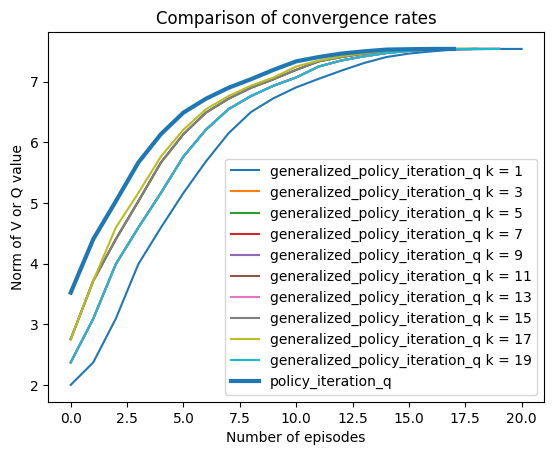

TypeError: cannot unpack non-iterable NoneType object

In [60]:
envs = [env1, env2, env3, env4, env5]
k_values, updates,iterations, temps, labels = plot_convergence_vi_pi_q(env1, 1, 21,2, False)

1
2
3
4
5
6
7
8
9


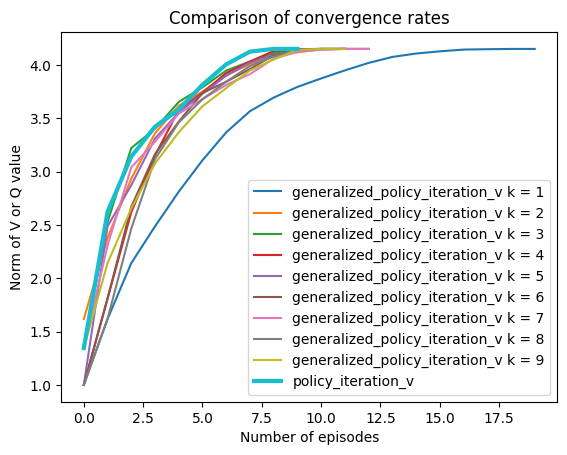

TypeError: cannot unpack non-iterable NoneType object

In [56]:
envs = [env1, env2, env3, env4, env5]
k_values, updates,iterations, temps, labels = plot_convergence_vi_pi(env1, 1, 10, False)

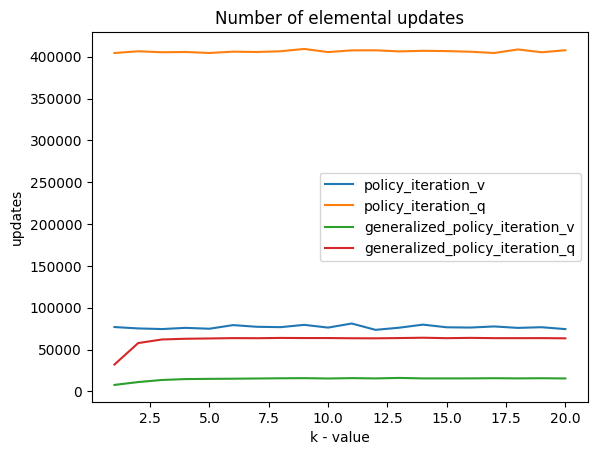

<Figure size 640x480 with 0 Axes>

In [75]:
plot_from_lists(k_values, updates, labels, "Number of elemental updates", "k - value", "updates")

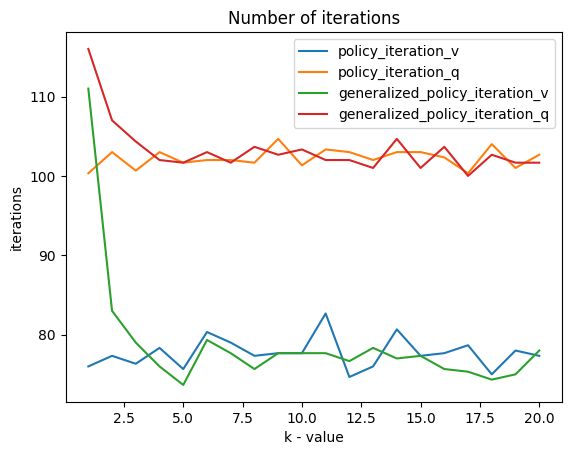

<Figure size 640x480 with 0 Axes>

In [76]:
plot_from_lists(k_values, iterations, labels, "Number of iterations", "k - value", "iterations")

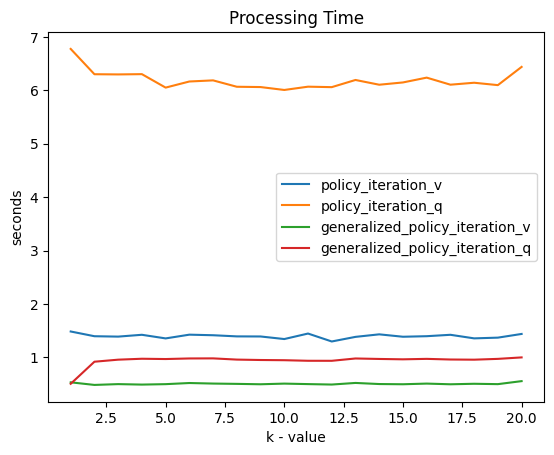

<Figure size 640x480 with 0 Axes>

In [71]:
plot_from_lists(k_values, [t/ 20 for t in temps], labels, "Processing Time", "k - value", "seconds")